In [1]:
import numpy as np
import torch
import random

In [2]:
#====================Random seed====================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 100% deterministic but slower training
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [3]:
#====================Dataset====================
import cv2
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

batch_size = 256

class dataset(Dataset):
    def __init__(self, data, transform=None):
        self.data=data
        self.transform=transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img, _ = self.data[idx]
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        if self.transform:
            img = self.transform(img)
            L = img[0:1, :, :]
            ab = (img[1:3, :, :]*255 - 128) / 128
        else:
            img = torch.from_numpy(img.transpose(2,0,1)).float()
            L = img[0:1, :, :] / 255
            ab = (img[1:3, :, :]- 128) / 128
        return L, ab
train_dataset = dataset(datasets.CIFAR10(root="./data", train=True, download=True), transform=transforms.ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_dataset = dataset(datasets.CIFAR10(root="./data", train=False, download=True), transform=transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

100%|██████████| 170M/170M [00:05<00:00, 28.8MB/s]


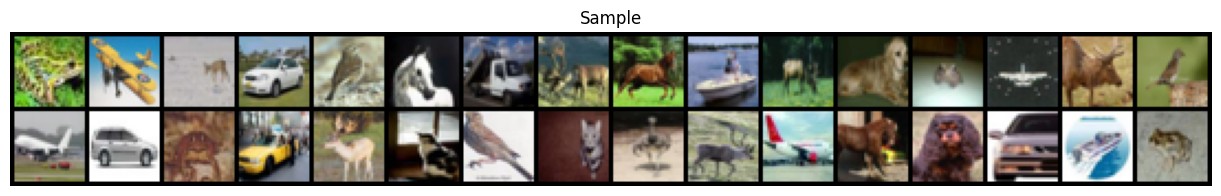

In [4]:
#====================Show data====================
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
def imshow(L, ab, title):
    L = L * 255
    ab = ab * 128 + 128
    img = np.concatenate([L.numpy(), ab.numpy()], axis=1)
    img = img[:32, :, :, :]
    img = np.transpose(img, (0, 2, 3, 1))
    img = np.clip(np.rint(img), 0, 255).astype(np.uint8)
    img = [torch.from_numpy(cv2.cvtColor(img[i], cv2.COLOR_LAB2RGB)).permute(2, 0, 1) for i in range(len(img))] # conver lab to rgb
    img = torch.stack(img, dim=0)
    grid = make_grid(img, nrow=16, padding=2)
    
    plt.figure(figsize=(16,2))
    plt.imshow(grid.permute(1,2,0).numpy()) 
    plt.title(title)
    plt.axis('off')
    plt.show()

L, ab = next(iter(train_dataloader))
imshow(L, ab, "Sample")

In [5]:
#====================Model====================
import torch.nn as nn
class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim, latent=False):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=input_dim, out_channels=output_dim, kernel_size=3, stride=1, padding='same')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.latent = latent
        
    def forward(self, x):
        conv = self.conv(x)
        conv = self.relu(conv)
        if self.latent==False:
            pool = self.pool(conv)
        else:
            pool = None
        return conv, pool

class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.uconv = nn.ConvTranspose2d(in_channels=input_dim, out_channels=output_dim, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv = nn.Conv2d(in_channels=input_dim, out_channels=output_dim, kernel_size=3, stride=1, padding='same')
        self.relu = nn.ReLU()
        
    def forward(self, x, skip_block):
        uconv = self.uconv(x)
        con = torch.concat([skip_block, uconv], dim=1)
        conv = self.conv(con)
        conv = self.relu(conv)
        return conv
        
class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoding
        self.enc_block_1 = Encoder(1, 32)
        self.enc_block_2 = Encoder(32, 64)
        self.enc_block_3 = Encoder(64, 128)
        self.enc_block_4 = Encoder(128, 256)
        self.enc_block_5 = Encoder(256, 512, latent=True)

        # Decoding
        self.dec_block_4 = Decoder(512, 256)
        self.dec_block_3 = Decoder(256, 128)
        self.dec_block_2 = Decoder(128, 64)
        self.dec_block_1 = Decoder(64, 32)

        # Compute ab channels
        self.compute = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=2, kernel_size=1, stride=1, padding='same'),
        )
        
    def forward(self, x):
        # input shape (B, 1, 32, 32)
        s1, p1 = self.enc_block_1(x) # (B, 32, 32, 32), (B, 32, 16, 16)
        s2, p2 = self.enc_block_2(p1) # (B, 64, 32, 32), (B, 64, 8, 8)
        s3, p3 = self.enc_block_3(p2) # (B, 128, 8, 8), (B, 128, 4, 4)
        s4, p4 = self.enc_block_4(p3) # (B, 256, 4, 4), (B, 256, 2, 2)
        latent, _ = self.enc_block_5(p4) # (B, 512, 2, 2)

        d4 = self.dec_block_4(latent, s4) # (B, 256, 4, 4)
        d3 = self.dec_block_3(d4, s3) # (B, 128, 8, 8)
        d2 = self.dec_block_2(d3, s2) # (B, 64, 16, 16)
        d1 = self.dec_block_1(d2, s1) # (B, 32, 32, 32)

        ab = self.compute(d1) #(B, 2, 32, 32)
        return ab

In [6]:
#====================Shape check====================
test = Unet()
data, label = next(iter(train_dataloader))
test(data).shape

torch.Size([256, 2, 32, 32])

In [7]:
#====================Train config====================
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constant
EPOCHS = 200

# Model, optimizer, loss function
model = Unet().to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
# ================== Train loop =================
train_logs = []
for epoch in range(EPOCHS+1):
    model.train()
    train_loss = test_loss = n_batches = 0
    for img, target in train_dataloader:
        img, target = img.to(device), target.to(device)
        optimizer.zero_grad()
        pred = model(img)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for img, target in test_dataloader:
            img, target = img.to(device), target.to(device)
            pred = model(img)
            loss = criterion(pred, target)
            test_loss += loss.item()
    train_logs.append(train_loss)
    if epoch%10==0:
        torch.save(model.state_dict(), f"Unet_reg_epoch_{epoch}.pth")
        print(f"Epoch: {epoch} | train_loss: {train_loss:.6f} | test_loss: {test_loss:.6f}")

Epoch: 0 | train_loss: 2.136908 | test_loss: 0.404650
Epoch: 10 | train_loss: 1.693542 | test_loss: 0.353955
Epoch: 20 | train_loss: 1.363920 | test_loss: 0.369163
Epoch: 30 | train_loss: 1.043631 | test_loss: 0.416541
Epoch: 40 | train_loss: 0.841411 | test_loss: 0.410346
Epoch: 50 | train_loss: 0.720640 | test_loss: 0.436773
Epoch: 60 | train_loss: 0.643217 | test_loss: 0.428704
Epoch: 70 | train_loss: 0.586181 | test_loss: 0.442235
Epoch: 80 | train_loss: 0.543828 | test_loss: 0.454697
Epoch: 90 | train_loss: 0.523156 | test_loss: 0.448302
Epoch: 100 | train_loss: 0.483640 | test_loss: 0.447503
Epoch: 110 | train_loss: 0.463776 | test_loss: 0.449895
Epoch: 120 | train_loss: 0.449237 | test_loss: 0.449746
Epoch: 130 | train_loss: 0.435698 | test_loss: 0.463467
Epoch: 140 | train_loss: 0.415658 | test_loss: 0.456295
Epoch: 150 | train_loss: 0.407947 | test_loss: 0.455005
Epoch: 160 | train_loss: 0.396321 | test_loss: 0.462131
Epoch: 170 | train_loss: 0.391917 | test_loss: 0.471745
Epo

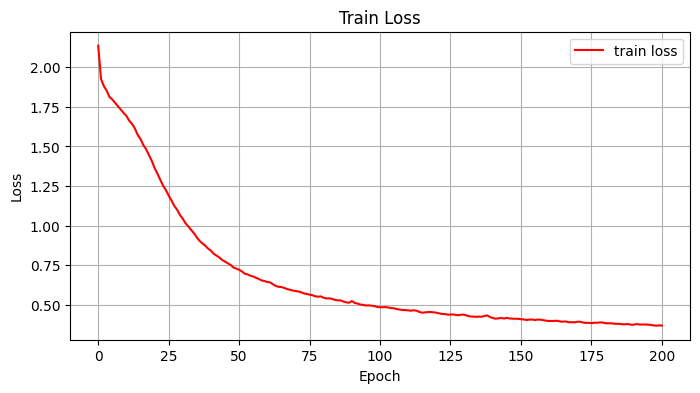

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

epochs = range(0, len(train_logs))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(epochs, train_logs, label="train loss", color="red")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Train Loss")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # ép tick nguyên
plt.show()

In [10]:
#====================Load checkpoint====================
Unet_50 = Unet().to(device)
Unet_100 = Unet().to(device)
Unet_150 = Unet().to(device)
Unet_200 = Unet().to(device)

checkpoint = torch.load("Unet_reg_epoch_50.pth", map_location=device)
Unet_50.load_state_dict(checkpoint)
checkpoint = torch.load("Unet_reg_epoch_100.pth", map_location=device)
Unet_100.load_state_dict(checkpoint)
checkpoint = torch.load("Unet_reg_epoch_150.pth", map_location=device)
Unet_150.load_state_dict(checkpoint)
checkpoint = torch.load("Unet_reg_epoch_200.pth", map_location=device)
Unet_200.load_state_dict(checkpoint)

<All keys matched successfully>

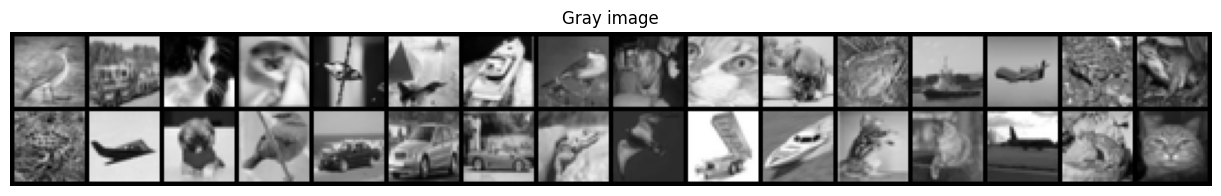

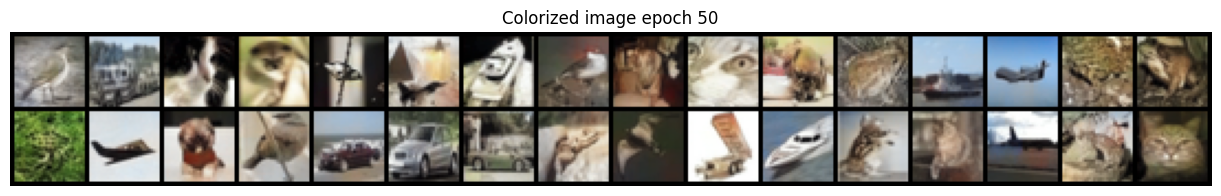

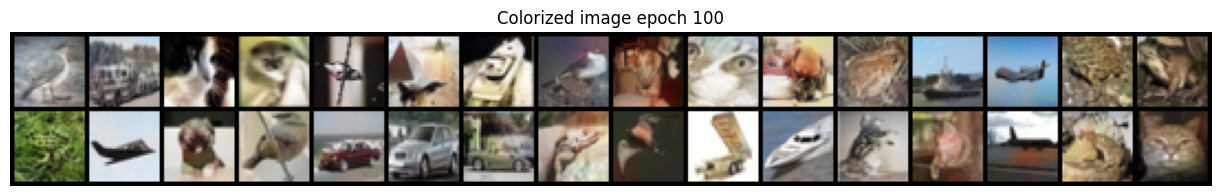

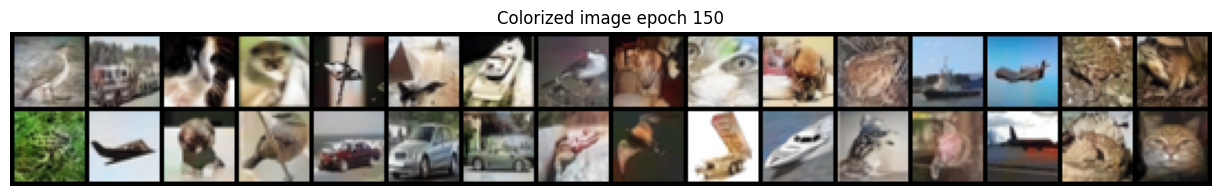

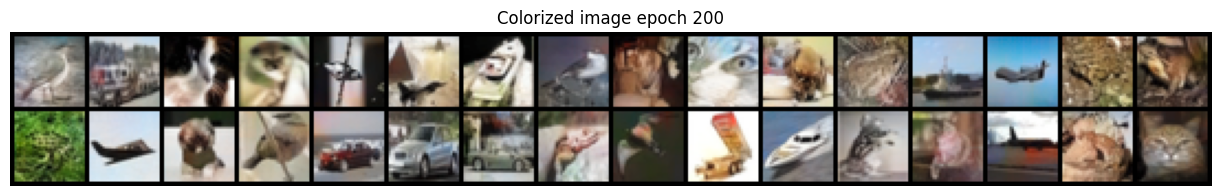

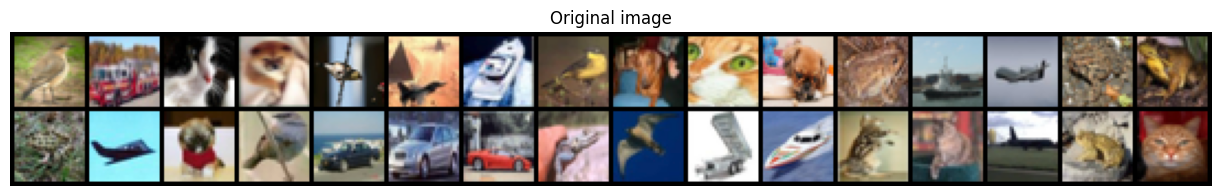

In [11]:
#====================Inference====================
with torch.no_grad():
    L, ab = next(iter(test_dataloader))
    # Show gray image
    B, C, H, W = L.shape
    imshow(L, torch.full((B, 2, H, W), 0, dtype=L.dtype), "Gray image")
    
    # Show colorized image
    L = L.to(device)
    ab_hat = Unet_50(L)
    L, ab_hat = L.to("cpu"), ab_hat.to("cpu")
    imshow(L, ab_hat, "Colorized image epoch 50")
    
    # Show colorized image
    L = L.to(device)
    ab_hat = Unet_100(L)
    L, ab_hat = L.to("cpu"), ab_hat.to("cpu")
    imshow(L, ab_hat, "Colorized image epoch 100")

    # Show colorized image
    L = L.to(device)
    ab_hat = Unet_150(L)
    L, ab_hat = L.to("cpu"), ab_hat.to("cpu")
    imshow(L, ab_hat, "Colorized image epoch 150")

    # Show colorized image
    L = L.to(device)
    ab_hat = Unet_200(L)
    L, ab_hat = L.to("cpu"), ab_hat.to("cpu")
    imshow(L, ab_hat, "Colorized image epoch 200")
    
    # Show orignal image
    imshow(L, ab, "Original image")